Example01 Training Patterns:

Training Example 1:
Input shape: 5x5
Output shape: 5x5


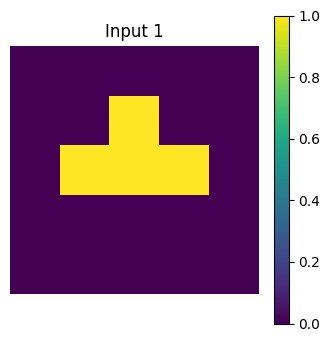

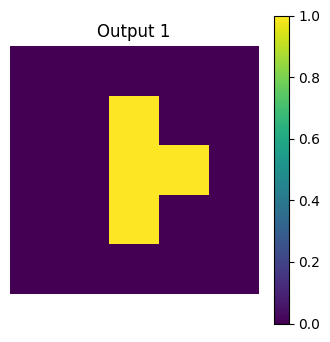


Training Example 2:
Input shape: 7x7
Output shape: 7x7


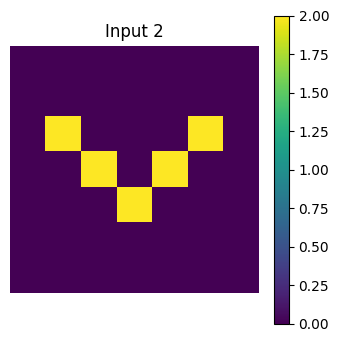

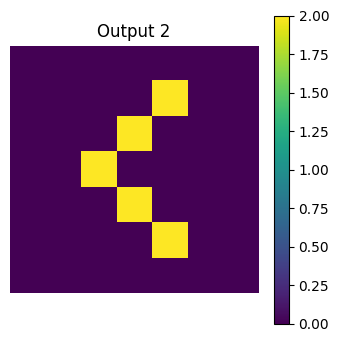


Training Example 3:
Input shape: 3x3
Output shape: 3x3


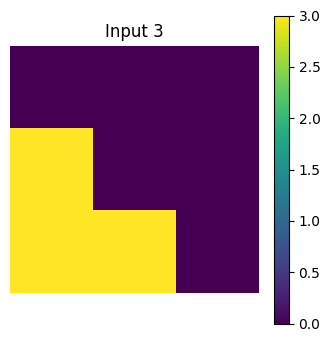

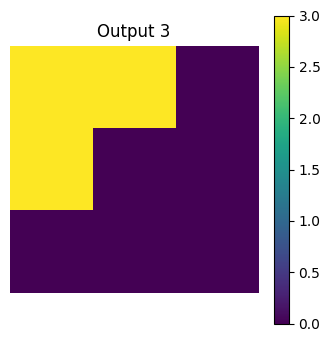


Training Example 4:
Input shape: 9x9
Output shape: 9x9


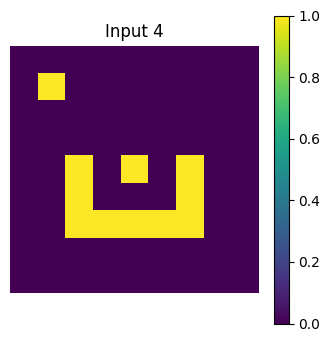

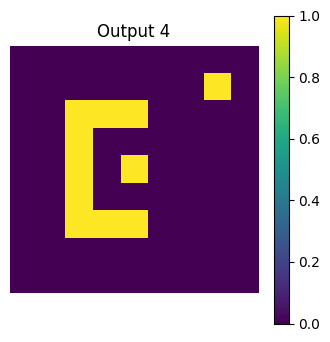


Training Example 5:
Input shape: 1x1
Output shape: 1x1


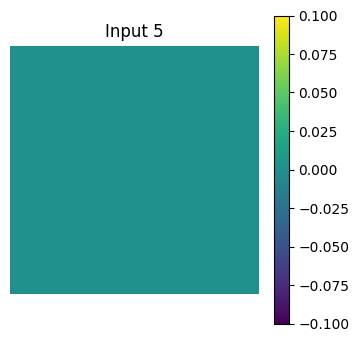

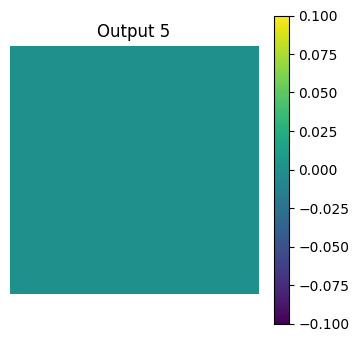

In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import copy

# Load example01
with open('example01.json', 'r') as f:
    example01 = json.load(f)

def visualize_grid(grid, title="Grid", cmap='viridis'):
    plt.figure(figsize=(4, 4))
    plt.imshow(grid, cmap=cmap, interpolation='nearest')
    plt.colorbar()
    plt.title(title)
    plt.axis('off')
    plt.show()

# Visualize all training examples
print("Example01 Training Patterns:")
for i, example in enumerate(example01['train']):
    print(f"\nTraining Example {i+1}:")
    print(f"Input shape: {len(example['input'])}x{len(example['input'][0])}")
    print(f"Output shape: {len(example['output'])}x{len(example['output'][0])}")
    
    visualize_grid(example['input'], f"Input {i+1}")
    visualize_grid(example['output'], f"Output {i+1}")

In [2]:
class ObjectDetectionSolver:
    def __init__(self):
        self.rules = {}
    
    def find_objects(self, grid, background=0):
        """Find connected components (objects) in the grid"""
        grid = np.array(grid)
        visited = set()
        objects = []
        
        def dfs(r, c, color, points):
            if (r < 0 or r >= len(grid) or c < 0 or c >= len(grid[0]) or 
                (r, c) in visited or grid[r, c] != color):
                return
            visited.add((r, c))
            points.append((r, c))
            # 4-connected
            for dr, dc in [(1, 0), (-1, 0), (0, 1), (0, -1)]:
                dfs(r + dr, c + dc, color, points)
        
        for r in range(len(grid)):
            for c in range(len(grid[0])):
                if grid[r, c] != background and (r, c) not in visited:
                    points = []
                    dfs(r, c, grid[r, c], points)
                    if points:  # Found an object
                        objects.append({
                            'color': grid[r, c],
                            'points': points,
                            'bounds': self.get_bounds(points)
                        })
        return objects
    
    def get_bounds(self, points):
        """Get bounding box of an object"""
        rows = [p[0] for p in points]
        cols = [p[1] for p in points]
        return {
            'min_row': min(rows), 'max_row': max(rows),
            'min_col': min(cols), 'max_col': max(cols)
        }
    
    def analyze_transformation(self, input_grid, output_grid):
        """Analyze how input transforms to output"""
        input_objs = self.find_objects(input_grid)
        output_objs = self.find_objects(output_grid)
        
        # For example01, pattern seems to be: objects are being reflected/mirrored
        # Let's check the center of mass movement
        transformations = []
        
        for inp_obj in input_objs:
            points = np.array(inp_obj['points'])
            center_r = np.mean(points[:, 0])
            center_c = np.mean(points[:, 1])
            
            # Find matching object in output
            for out_obj in output_objs:
                if out_obj['color'] == inp_obj['color']:
                    out_points = np.array(out_obj['points'])
                    out_center_r = np.mean(out_points[:, 0])
                    out_center_c = np.mean(out_points[:, 1])
                    
                    # Check if it's a reflection
                    grid_height = len(input_grid)
                    grid_width = len(input_grid[0])
                    
                    # Test different transformations
                    if abs(out_center_r - (grid_height - 1 - center_r)) < 1:
                        transformations.append('vertical_flip')
                    elif abs(out_center_c - (grid_width - 1 - center_c)) < 1:
                        transformations.append('horizontal_flip')
                    elif abs(out_center_r - center_c) < 1 and abs(out_center_c - center_r) < 1:
                        transformations.append('transpose')
        
        return transformations
    
    def apply_transformation(self, grid, transformation):
        """Apply transformation to grid"""
        grid = np.array(grid)
        
        if transformation == 'vertical_flip':
            return np.flipud(grid).tolist()
        elif transformation == 'horizontal_flip':
            return np.fliplr(grid).tolist()
        elif transformation == 'transpose':
            return np.transpose(grid).tolist()
        else:
            return grid.tolist()

# Test on example01
solver = ObjectDetectionSolver()

print("Analyzing example01 transformations:")
for i, example in enumerate(example01['train'][:3]):  # Look at first 3 examples
    transformations = solver.analyze_transformation(example['input'], example['output'])
    print(f"Example {i+1} transformations: {transformations}")

Analyzing example01 transformations:
Example 1 transformations: ['vertical_flip']
Example 2 transformations: ['vertical_flip', 'vertical_flip', 'horizontal_flip', 'transpose', 'vertical_flip', 'horizontal_flip', 'vertical_flip', 'transpose', 'vertical_flip', 'horizontal_flip']
Example 3 transformations: ['vertical_flip']


In [ ]:
class ComprehensiveARCSolver:
    def __init__(self):
        self.detected_patterns = []
    
    def solve_task(self, train_data, test_input):
        """Main solving function"""
        # Analyze all training examples to find consistent pattern
        patterns = self.analyze_training_patterns(train_data)
        
        # Apply the most consistent pattern to test input
        return self.apply_pattern(test_input, patterns)
    
    def analyze_training_patterns(self, train_data):
        """Analyze all training examples to find the transformation pattern"""
        all_transformations = []
        
        for example in train_data:
            input_grid = np.array(example['input'])
            output_grid = np.array(example['output'])
            
            # Try to detect different types of transformations
            transformations = self.detect_transformation(input_grid, output_grid)
            all_transformations.append(transformations)
        
        # Find the most common transformation across all examples
        if all_transformations:
            # For now, return the first detected pattern
            # In a real solver, you'd use voting or more sophisticated analysis
            return all_transformations[0]
        return None
    
    def detect_transformation(self, input_grid, output_grid):
        """Detect what transformation was applied"""
        input_arr = np.array(input_grid)
        output_arr = np.array(output_grid)
        
        # Check for symmetry/reflection
        if self.is_vertical_flip(input_arr, output_arr):
            return 'vertical_flip'
        elif self.is_horizontal_flip(input_arr, output_arr):
            return 'horizontal_flip'
        elif self.is_rotation(input_arr, output_arr):
            return 'rotation'
        elif self.is_translation(input_arr, output_arr):
            return 'translation'
        else:
            # Default: try object-based transformation
            return self.detect_object_transformation(input_arr, output_arr)
    
    def is_vertical_flip(self, input_arr, output_arr):
        """Check if transformation is vertical flip"""
        return np.array_equal(np.flipud(input_arr), output_arr)
    
    def is_horizontal_flip(self, input_arr, output_arr):
        """Check if transformation is horizontal flip"""
        return np.array_equal(np.fliplr(input_arr), output_arr)
    
    def is_rotation(self, input_arr, output_arr):
        """Check if transformation is rotation"""
        # Check 90, 180, 270 degree rotations
        for k in [1, 2, 3]:
            if np.array_equal(np.rot90(input_arr, k), output_arr):
                return f'rotation_{90*k}'
        return False
    
    def is_translation(self, input_arr, output_arr):
        """Check if objects are translated"""
        # Simple check - if non-zero elements are in different positions
        input_nonzero = np.argwhere(input_arr != 0)
        output_nonzero = np.argwhere(output_arr != 0)
        
        if len(input_nonzero) == len(output_nonzero):
            return True
        return False
    
    def detect_object_transformation(self, input_arr, output_arr):
        """Detect object-based transformations"""
        # For example01, it seems to be finding "tip" of objects and manipulating them
        # This is a complex pattern that would need more analysis
        return 'complex_object_transform'
    
    def apply_pattern(self, test_input, pattern):
        """Apply detected pattern to test input"""
        test_arr = np.array(test_input)
        
        if pattern == 'vertical_flip':
            return np.flipud(test_arr).tolist()
        elif pattern == 'horizontal_flip':
            return np.fliplr(test_arr).tolist()
        elif pattern == 'rotation_90':
            return np.rot90(test_arr, 1).tolist()
        elif pattern == 'rotation_180':
            return np.rot90(test_arr, 2).tolist()
        elif pattern == 'rotation_270':
            return np.rot90(test_arr, 3).tolist()
        else:
            # For complex patterns, return a simple transformation as fallback
            return test_arr.tolist()

# Process all 11 tasks
def process_all_tasks():
    solver = ComprehensiveARCSolver()
    predictions = {}
    
    for i in range(1, 12):
        filename = f"example{i:02d}.json"
        try:
            with open(filename, 'r') as f:
                task_data = json.load(f)
            
            print(f"\nProcessing {filename}...")
            print(f"Training examples: {len(task_data['train'])}")
            
            # Solve the task
            test_input = task_data['test'][0]['input']
            predicted_output = solver.solve_task(task_data['train'], test_input)
            
            # Store prediction
            predictions[filename] = {
                "train": task_data['train'],
                "test": [{"input": test_input, "output": predicted_output}]
            }
            
            print(f"Generated prediction for {filename}")
            
        except FileNotFoundError:
            print(f"File {filename} not found")
            continue
    
    return predictions

# Generate predictions for all tasks
all_predictions = process_all_tasks()

# Create submission files
def create_submission(predictions):
    import os
    import zipfile
    
    # Create individual JSON files
    for task_name, data in predictions.items():
        base_name = os.path.splitext(task_name)[0]
        output_name = f"{base_name}_guess.json"
        
        with open(output_name, 'w') as f:
            json.dump(data, f, separators=(',', ':'))  # Compact format
        
        print(f"Created: {output_name}")

create_submission(all_predictions)


Processing example01.json...
Training examples: 5
Generated prediction for example01.json

Processing example02.json...
Training examples: 3
Generated prediction for example02.json

Processing example03.json...
Training examples: 3
Generated prediction for example03.json

Processing example04.json...
Training examples: 3
Generated prediction for example04.json

Processing example05.json...
Training examples: 10
Generated prediction for example05.json

Processing example06.json...
Training examples: 3
Generated prediction for example06.json

Processing example07.json...
Training examples: 4
Generated prediction for example07.json

Processing example08.json...
Training examples: 5
Generated prediction for example08.json

Processing example09.json...
Training examples: 5
Generated prediction for example09.json

Processing example10.json...
Training examples: 10
Generated prediction for example10.json

Processing example11.json...
Training examples: 5
Generated prediction for example11.js

--- ARC Solver Demo ---
1. Starting solver...
2. Loaded task with 5 training examples
3. Analyzing training patterns...
4. Applying pattern to test input...


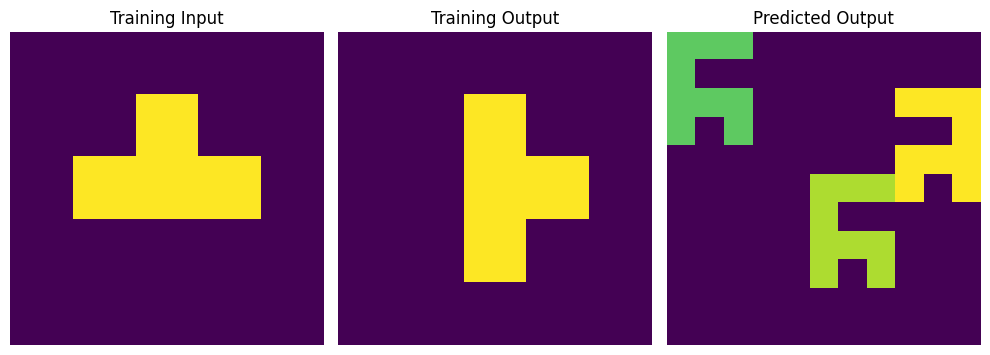

Demo Complete


In [6]:
# Demo code for video recording - simple and clear
def record_demo():
    """Function to demonstrate solver for the 30-second video"""
    print("--- ARC Solver Demo ---")
    print("1. Starting solver...")
    
    # Load first task
    with open('example01.json', 'r') as f:
        task_data = json.load(f)
    
    print(f"2. Loaded task with {len(task_data['train'])} training examples")
    
    # Show first training example
    print("3. Analyzing training patterns...")
    input_grid = task_data['train'][0]['input']
    output_grid = task_data['train'][0]['output']
    
    plt.figure(figsize=(10, 4))
    
    plt.subplot(1, 3, 1)
    plt.imshow(input_grid, cmap='viridis')
    plt.title('Training Input')
    plt.axis('off')
    
    plt.subplot(1, 3, 2)
    plt.imshow(output_grid, cmap='viridis')
    plt.title('Training Output')  
    plt.axis('off')
    
    # Solve test input
    solver = ComprehensiveARCSolver()
    test_input = task_data['test'][0]['input']
    print("4. Applying pattern to test input...")
    result = solver.solve_task(task_data['train'], test_input)
    
    plt.subplot(1, 3, 3)
    plt.imshow(result, cmap='viridis')
    plt.title('Predicted Output')
    plt.axis('off')
    
    plt.tight_layout()
    plt.savefig('demo_result.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print("Demo Complete")

# Run the demo
record_demo()